In [ ]:
#В данном проекте попробуем расчитать дельты от нижней/верхней границы цены до цены открытия свечи 
#с использованием алгоритма линейной регресии на основании расчитанных временных рядов (time series) объемов покупок и продаж

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error, mean_squared_log_error, explained_variance_score

In [2]:
#Загружаем датасет
import pandas as pd
df = pd.read_csv("pyprog/ex/BNB_5m_spot.csv", sep="|")
print(df)

        Unnamed: 0         timeopen BNB  opens BNB  high BNB  low BNB  \
0                0  2023-01-01 00:00:00      246.3     246.4    245.9   
1                1  2023-01-01 00:05:00      246.2     246.2    246.0   
2                2  2023-01-01 00:10:00      246.1     246.1    246.0   
3                3  2023-01-01 00:15:00      246.0     246.2    245.8   
4                4  2023-01-01 00:20:00      246.2     246.5    246.1   
...            ...                  ...        ...       ...      ...   
100690      100690  2024-05-17 09:30:00      576.7     577.6    576.4   
100691      100691  2024-05-17 09:35:00      577.4     577.8    577.1   
100692      100692  2024-05-17 09:40:00      577.2     577.3    576.7   
100693      100693  2024-05-17 09:45:00      576.7     577.2    576.6   
100694      100694  2024-05-17 09:50:00      576.9     577.0    576.4   

        closes BNB  volume BNB        timeclose BNB  volume_q BNB  kol BNB  \
0            246.2     440.108  2023-01-01 00

In [3]:
#Ограничиваем датасет 2-мя атрибутами: объем сделок на покупку и время открытия, меняем типы данных, если необходимо
dfv = df[["timeopen BNB","taker_q BNB"]]
dfv = dfv[0:100000]
dfv = dfv.rename(columns={"taker_q BNB": "vol","timeopen BNB":"timeopen"})
dfv["timeopen"] = pd.to_datetime(dfv["timeopen"])
print(dfv)
dfv.dtypes

                 timeopen          vol
0     2023-01-01 00:00:00   27774.6386
1     2023-01-01 00:05:00    7159.3684
2     2023-01-01 00:10:00   49649.1984
3     2023-01-01 00:15:00   75929.1050
4     2023-01-01 00:20:00   22204.3352
...                   ...          ...
99995 2024-05-13 10:55:00  154718.7293
99996 2024-05-13 11:00:00  299543.0948
99997 2024-05-13 11:05:00  397800.0412
99998 2024-05-13 11:10:00  263328.9406
99999 2024-05-13 11:15:00  302236.1224

[100000 rows x 2 columns]


timeopen    datetime64[ns]
vol                float64
dtype: object

In [4]:
#формируем индекс из даты
dfv = dfv[["timeopen","vol"]].set_index("timeopen")
dfv.head()

,vol
timeopen,
2023-01-01 00:00:00,27774.6386
2023-01-01 00:05:00,7159.3684
2023-01-01 00:10:00,49649.1984
2023-01-01 00:15:00,75929.1050
2023-01-01 00:20:00,22204.3352


<Axes: xlabel='timeopen'>

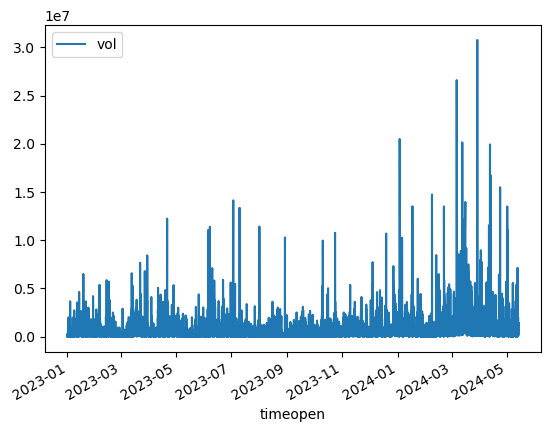

In [5]:
#посмотрим что получилось
dfv.plot()

In [6]:
#для обогащения датасета признаками пишем функцию по определению среднего значения с группировкой по дате/времени
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())


In [7]:
print(dfv)

                             vol
timeopen                        
2023-01-01 00:00:00   27774.6386
2023-01-01 00:05:00    7159.3684
2023-01-01 00:10:00   49649.1984
2023-01-01 00:15:00   75929.1050
2023-01-01 00:20:00   22204.3352
...                          ...
2024-05-13 10:55:00  154718.7293
2024-05-13 11:00:00  299543.0948
2024-05-13 11:05:00  397800.0412
2024-05-13 11:10:00  263328.9406
2024-05-13 11:15:00  302236.1224

[100000 rows x 1 columns]


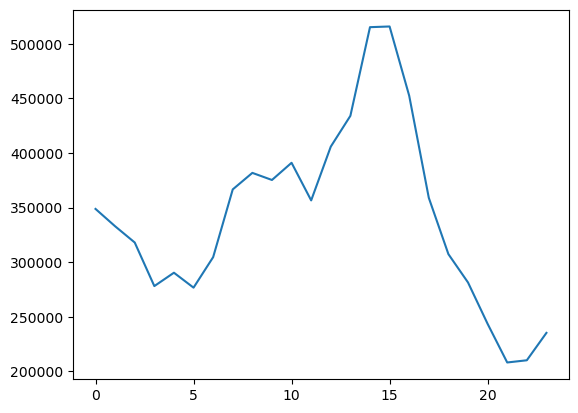

In [8]:
#добавим средние значения объема с группировкой по часам
dfv["hour"] = dfv.index.hour
d = code_mean(dfv, "hour", "vol")
plt.plot(d.keys(), d.values())

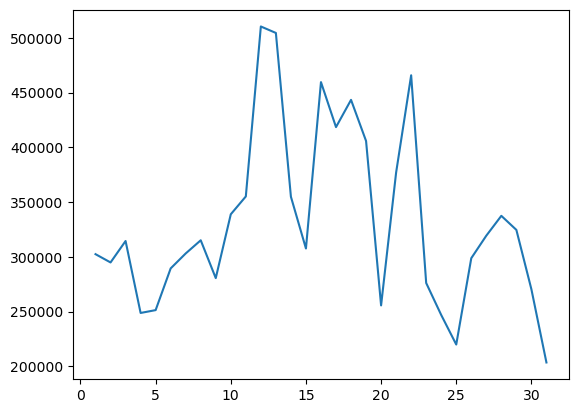

In [9]:
#добавим средние значения объема с группировкой по дням
dfv["day"] = dfv.index.day
dm = code_mean(dfv, "day", "vol")
plt.plot(dm.keys(), dm.values())

In [10]:
#Пишем функцию в которой:
#1) Разбиваем данные на тренировочную и тестовую части
#2) Генерируем лаговые признаки
#3) Генерируем агрегированные признаки
def preprocess_data(data, lag_start=1, lag_end=21, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data.vol.shift(i)

    data["hour"] = data.index.hour
    data["day"] = data.index.day

    # считаем средние только по тренировочной части, чтобы избежать лика
    data["hour_average"] = list(map(code_mean(data[:test_index], "hour", "vol").get, data.hour))
    data["day_average"] = list(map(code_mean(data[:test_index], "day", "vol").get, data.day))

    # выкидываем закодированные средними признаки
    data.drop(["hour", "day"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["vol"], axis=1)
    y_train = data.loc[:test_index]["vol"]
    X_test = data.loc[test_index:].drop(["vol"], axis=1)
    y_test = data.loc[test_index:]["vol"]

    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = preprocess_data(dfv, test_size=0.15, lag_start=1, lag_end=21)
X_test.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,hour_average,day_average
85000,553771.3111,419507.2400,884914.0903,233528.6607,363480.6989,456001.4585,489252.5534,510207.9923,364834.7680,526915.3761,...,543402.4465,422485.8217,1.089027e+06,2.218840e+05,8.732993e+05,4.184613e+05,3.233602e+05,858194.8033,261218.176434,220341.789703
85001,424663.1487,553771.3111,419507.2400,884914.0903,233528.6607,363480.6989,456001.4585,489252.5534,510207.9923,364834.7680,...,815092.8660,543402.4465,4.224858e+05,1.089027e+06,2.218840e+05,8.732993e+05,4.184613e+05,323360.1772,261218.176434,220341.789703
85002,896670.7302,424663.1487,553771.3111,419507.2400,884914.0903,233528.6607,363480.6989,456001.4585,489252.5534,510207.9923,...,295705.8508,815092.8660,5.434024e+05,4.224858e+05,1.089027e+06,2.218840e+05,8.732993e+05,418461.2844,261218.176434,220341.789703
85003,474531.2331,896670.7302,424663.1487,553771.3111,419507.2400,884914.0903,233528.6607,363480.6989,456001.4585,489252.5534,...,526915.3761,295705.8508,8.150929e+05,5.434024e+05,4.224858e+05,1.089027e+06,2.218840e+05,873299.3398,261218.176434,220341.789703
85004,678156.9936,474531.2331,896670.7302,424663.1487,553771.3111,419507.2400,884914.0903,233528.6607,363480.6989,456001.4585,...,364834.7680,526915.3761,2.957059e+05,8.150929e+05,5.434024e+05,4.224858e+05,1.089027e+06,221883.9912,251021.960581,220341.789703


Text(0.5, 1.0, 'Linear regression\n mean_absolute_error 333706.32730413484 degrees')

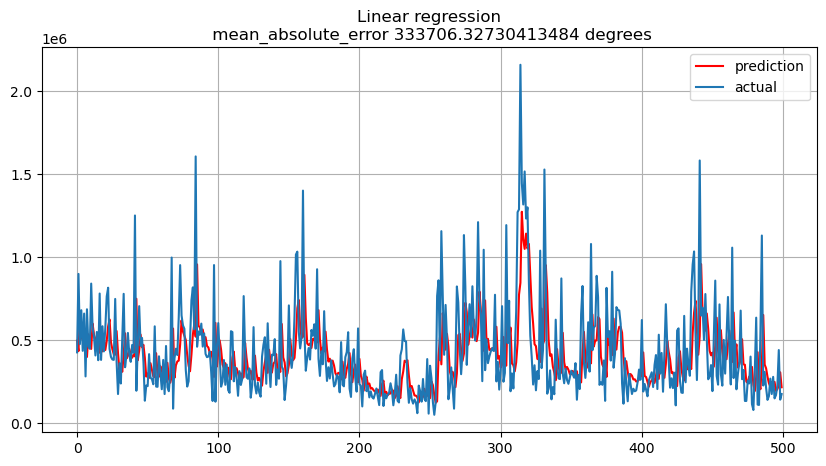

In [12]:
# Линейная регрессия (для наглядности на график выведем 500 первых значений из тестовой выборки)
# Понятно что Обсалютная ошибка будет большой, но это нам нужно просто для опредения какой метод взять
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds[0:500], "r", label="prediction")
plt.plot(y_test.values[0:500], label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n mean_absolute_error {mean_absolute_error(y_test,preds)} degrees")

Text(0.5, 1.0, 'DecisionTreeRegressor\n mean_absolute_error 478701.29220446013 degrees')

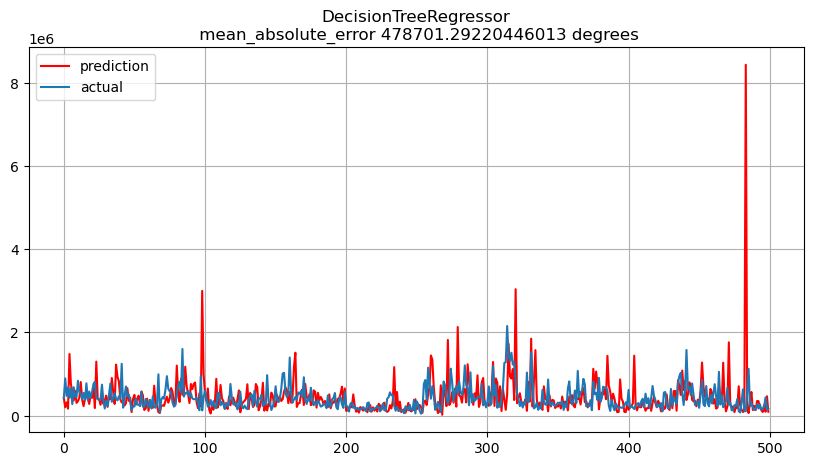

In [13]:
# Деревья решений (для наглядности на график выведем 500 значений)
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
preds = dt.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds[0:500], "r", label="prediction")
plt.plot(y_test.values[0:500], label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"DecisionTreeRegressor\n mean_absolute_error {mean_absolute_error(y_test,preds)} degrees")

Text(0.5, 1.0, 'RandomForestRegressor\n mean_absolute_error 350708.0240739107 degrees')

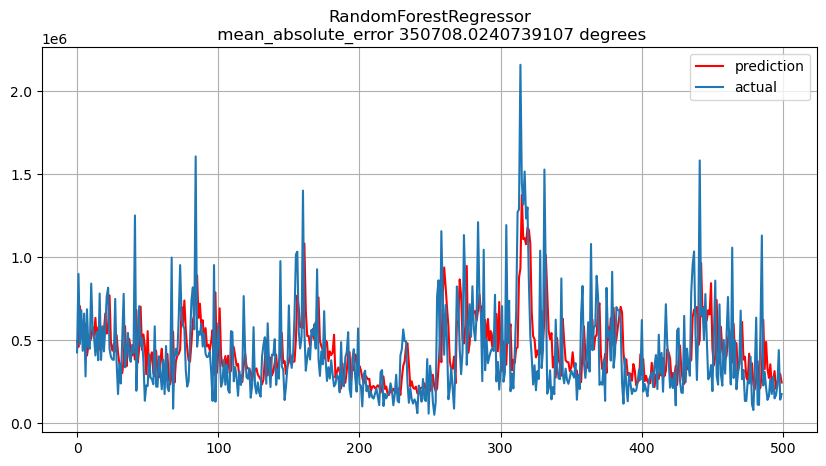

In [14]:
# Случайный лес (для наглядности на график выведем 500 значений)
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds[0:500], "r", label="prediction")
plt.plot(y_test.values[0:500], label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"RandomForestRegressor\n mean_absolute_error {mean_absolute_error(y_test,preds)} degrees")

Learning rate set to 0.219851
0:	learn: 406309.8977177	total: 3.34ms	remaining: 1s
1:	learn: 381174.6079604	total: 5.94ms	remaining: 886ms
2:	learn: 363822.0698350	total: 8.53ms	remaining: 844ms
3:	learn: 352987.6805542	total: 11.2ms	remaining: 830ms
4:	learn: 344426.0412796	total: 13.8ms	remaining: 812ms
5:	learn: 338783.5548542	total: 16.2ms	remaining: 792ms
6:	learn: 334885.0141817	total: 18.6ms	remaining: 780ms
7:	learn: 331413.3784615	total: 20.9ms	remaining: 764ms
8:	learn: 329184.1256158	total: 23.6ms	remaining: 762ms
9:	learn: 327686.7492331	total: 25.8ms	remaining: 749ms
10:	learn: 326432.5550630	total: 28.3ms	remaining: 743ms
11:	learn: 325523.1524519	total: 30.8ms	remaining: 739ms
12:	learn: 324514.5452595	total: 32.9ms	remaining: 726ms
13:	learn: 324033.0589362	total: 35.2ms	remaining: 718ms
14:	learn: 323398.3883975	total: 37.6ms	remaining: 714ms
15:	learn: 322787.5777760	total: 40.1ms	remaining: 712ms
16:	learn: 322243.5117506	total: 42.1ms	remaining: 702ms
17:	learn: 321

Text(0.5, 1.0, 'CatBoostRegressor\n mean_absolute_error 351773.30478194816 degrees')

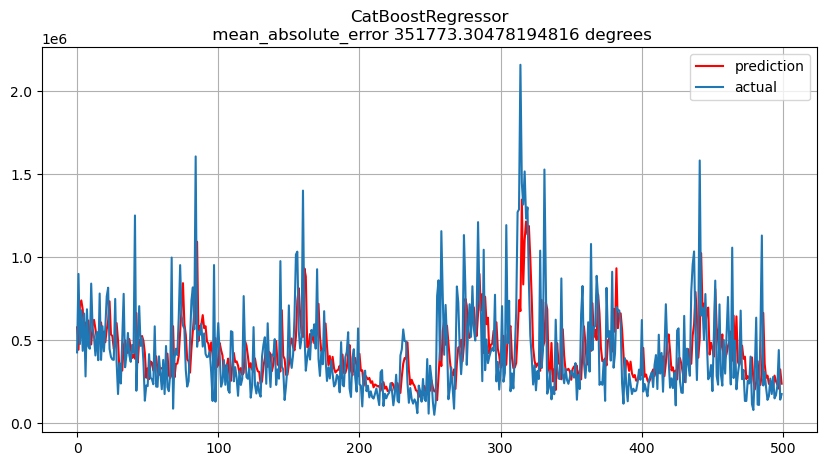

In [44]:
# Бустинг (для наглядности на график выведем 500 значений)
from catboost import CatBoostRegressor
cb = CatBoostRegressor(n_estimators=300)
cb.fit(X_train, y_train)
preds = cb.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds[0:500], "r", label="prediction")
plt.plot(y_test.values[0:500], label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"CatBoostRegressor\n mean_absolute_error {mean_absolute_error(y_test,preds)} degrees")

In [16]:
# По результату видим что наилучшие результаты показал метод линейной регрессии
# Аналогично поступаем с объемом продаж
dfv3 = df["volume_q BNB"]-df["taker_q BNB"]
dfv2 = pd.concat([df["timeopen BNB"],dfv3], axis=1)
dfv2 = dfv2[0:100000]
dfv2 = dfv2.rename(columns={0: "vol","timeopen BNB":"timeopen"})
dfv2["timeopen"] = pd.to_datetime(dfv2["timeopen"])
print(dfv2)

                 timeopen          vol
0     2023-01-01 00:00:00   80578.0431
1     2023-01-01 00:05:00   16704.9209
2     2023-01-01 00:10:00    9965.4600
3     2023-01-01 00:15:00   14910.0223
4     2023-01-01 00:20:00   14574.5563
...                   ...          ...
99995 2024-05-13 10:55:00  166002.1012
99996 2024-05-13 11:00:00  212640.9393
99997 2024-05-13 11:05:00  270360.4217
99998 2024-05-13 11:10:00   80231.4319
99999 2024-05-13 11:15:00  134559.0736

[100000 rows x 2 columns]


In [17]:
#формируем индекс из даты
dfv2 = dfv2[["timeopen","vol"]].set_index("timeopen")
dfv2.head()

,vol
timeopen,
2023-01-01 00:00:00,80578.0431
2023-01-01 00:05:00,16704.9209
2023-01-01 00:10:00,9965.4600
2023-01-01 00:15:00,14910.0223
2023-01-01 00:20:00,14574.5563


In [18]:
#средние значения по дням и числам считать и показывать не будем т.к. графики фактически будут такие же как и при покупках, сразу перейдем к формированию признаков
X_train2, X_test2, y_train2, y_test2 = preprocess_data(dfv2, test_size=0.15, lag_start=1, lag_end=21)
X_train2.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,hour_average,day_average
0,52355.5911,25101.1589,30411.1134,44930.9918,29180.7737,2445.2296,6832.1263,34620.7687,77744.0427,24824.8879,...,145382.7292,37942.6886,10520.6908,14574.5563,14910.0223,9965.4600,16704.9209,80578.0431,265085.088499,222846.96563
1,11273.3095,52355.5911,25101.1589,30411.1134,44930.9918,29180.7737,2445.2296,6832.1263,34620.7687,77744.0427,...,34584.8113,145382.7292,37942.6886,10520.6908,14574.5563,14910.0223,9965.4600,16704.9209,265085.088499,222846.96563
2,22990.6874,11273.3095,52355.5911,25101.1589,30411.1134,44930.9918,29180.7737,2445.2296,6832.1263,34620.7687,...,118035.8694,34584.8113,145382.7292,37942.6886,10520.6908,14574.5563,14910.0223,9965.4600,265085.088499,222846.96563
3,49032.1795,22990.6874,11273.3095,52355.5911,25101.1589,30411.1134,44930.9918,29180.7737,2445.2296,6832.1263,...,24824.8879,118035.8694,34584.8113,145382.7292,37942.6886,10520.6908,14574.5563,14910.0223,265085.088499,222846.96563
4,29899.6739,49032.1795,22990.6874,11273.3095,52355.5911,25101.1589,30411.1134,44930.9918,29180.7737,2445.2296,...,77744.0427,24824.8879,118035.8694,34584.8113,145382.7292,37942.6886,10520.6908,14574.5563,242422.832698,222846.96563


Text(0.5, 1.0, 'Linear regression\n mean_absolute_error 332832.590441625 degrees')

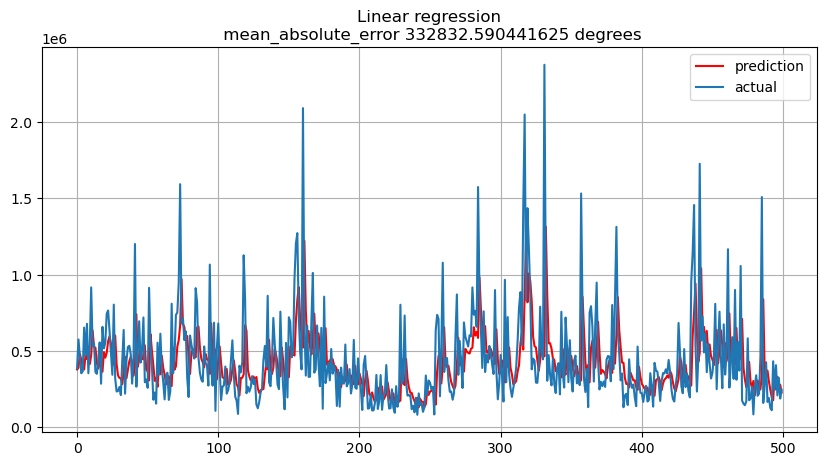

In [19]:
#Сейчас используем только модель линейной регресии т.к. она лучше всех себя показала на покупках
lr2 = LinearRegression()
lr2.fit(X_train2, y_train2)

preds2 = lr2.predict(X_test2)

plt.figure(figsize=(10, 5))
plt.plot(preds2[0:500], "r", label="prediction")
plt.plot(y_test2.values[0:500], label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n mean_absolute_error {mean_absolute_error(y_test2,preds2)} degrees")

In [20]:
#Теперь когда мы можем предсказать значения объемов на покупку и продажу посмотрим насколько сильно они влияют на изменение цены
#Для этого попробуем предсказать дельту цены за период времени взависимости от объема покупок и продаж
delta_up = df["high BNB"]-df["opens BNB"]
delta_down = df["opens BNB"]-df["low BNB"]
df_vol = df[["timeopen BNB","taker_q BNB"]]

In [21]:
df_delta_up = pd.concat([df_vol,dfv3,delta_up], axis = 1)
df_delta_up = df_delta_up[0:100000]
df_delta_up = df_delta_up.rename(columns={"taker_q BNB":"buy",0: "sell",1:"dup","timeopen BNB":"timeopen"})
df_delta_up["timeopen"] = pd.to_datetime(df_delta_up["timeopen"])
df_delta_up = df_delta_up[["timeopen","buy","sell","dup"]].set_index("timeopen")
print(df_delta_up)

                             buy         sell  dup
timeopen                                          
2023-01-01 00:00:00   27774.6386   80578.0431  0.1
2023-01-01 00:05:00    7159.3684   16704.9209  0.0
2023-01-01 00:10:00   49649.1984    9965.4600  0.0
2023-01-01 00:15:00   75929.1050   14910.0223  0.2
2023-01-01 00:20:00   22204.3352   14574.5563  0.3
...                          ...          ...  ...
2024-05-13 10:55:00  154718.7293  166002.1012  0.2
2024-05-13 11:00:00  299543.0948  212640.9393  0.6
2024-05-13 11:05:00  397800.0412  270360.4217  0.1
2024-05-13 11:10:00  263328.9406   80231.4319  0.8
2024-05-13 11:15:00  302236.1224  134559.0736  0.5

[100000 rows x 3 columns]


In [22]:
#Целевая переменная dup - дельта цены от верхней границы свечи до цены открытия
#Разбиваем датафрейм на трейн и тест, в этот раз воспользуемся стандартной функцией sklearn
from sklearn.model_selection import train_test_split
X = df_delta_up.drop("dup",axis = 1)
Y = df_delta_up["dup"]
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X, Y, test_size = 0.15, random_state = 777)

0.32199900000000004


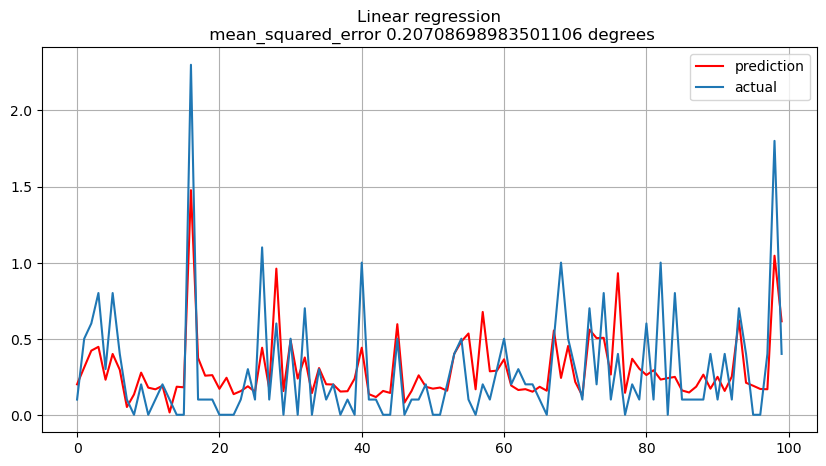

In [23]:
lr3 = LinearRegression()
lr3.fit(X_train3, Y_train3)

preds3 = lr3.predict(X_test3)

plt.figure(figsize=(10, 5))
plt.plot(preds3[0:100], "r", label="prediction")
plt.plot(Y_test3.values[0:100], label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n mean_squared_error {mean_absolute_error(Y_test3,preds3)} degrees")
print(Y.mean())

Text(0.5, 1.0, 'DecisionTreeRegressor\n mean_absolute_error 0.27656000000000297 degrees')

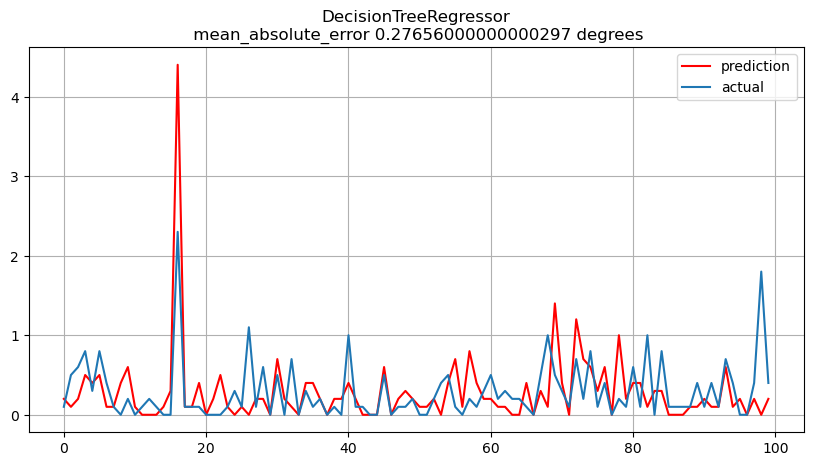

In [24]:
dt3 = DecisionTreeRegressor()
dt3.fit(X_train3, Y_train3)
preds3 = dt3.predict(X_test3)

plt.figure(figsize=(10, 5))
plt.plot(preds3[0:100], "r", label="prediction")
plt.plot(Y_test3.values[0:100], label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"DecisionTreeRegressor\n mean_absolute_error {mean_absolute_error(Y_test3,preds3)} degrees")

Text(0.5, 1.0, 'RandomForestRegressor\n mean_absolute_error 0.21677553333333333 degrees')

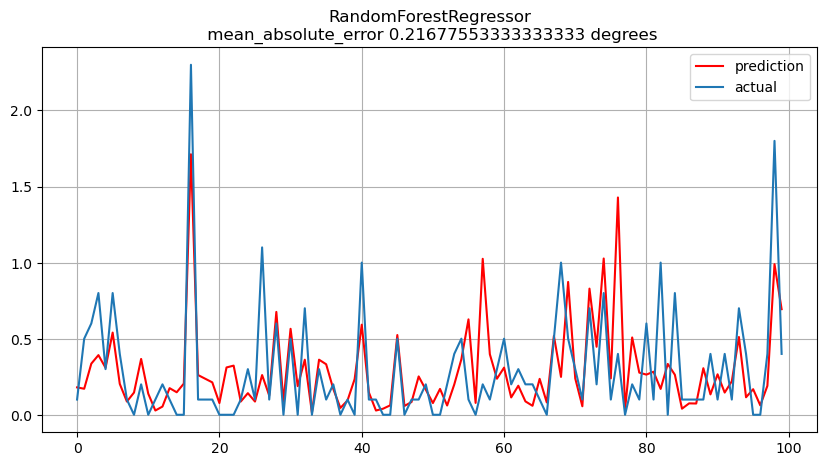

In [25]:
rf3 = RandomForestRegressor()
rf3.fit(X_train3, Y_train3)
preds3 = rf3.predict(X_test3)

plt.figure(figsize=(10, 5))
plt.plot(preds3[0:100], "r", label="prediction")
plt.plot(Y_test3.values[0:100], label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"RandomForestRegressor\n mean_absolute_error {mean_absolute_error(Y_test3,preds3)} degrees")

Learning rate set to 0.219851
0:	learn: 0.4806523	total: 2.51ms	remaining: 750ms
1:	learn: 0.4527309	total: 4.14ms	remaining: 617ms
2:	learn: 0.4333927	total: 5.73ms	remaining: 567ms
3:	learn: 0.4201110	total: 7.21ms	remaining: 533ms
4:	learn: 0.4114241	total: 8.85ms	remaining: 522ms
5:	learn: 0.4048441	total: 10.6ms	remaining: 521ms
6:	learn: 0.4002515	total: 12.3ms	remaining: 515ms
7:	learn: 0.3962188	total: 13.8ms	remaining: 503ms
8:	learn: 0.3932283	total: 15.3ms	remaining: 494ms
9:	learn: 0.3914524	total: 16.8ms	remaining: 488ms
10:	learn: 0.3899801	total: 18.2ms	remaining: 479ms
11:	learn: 0.3885334	total: 19.6ms	remaining: 469ms
12:	learn: 0.3876358	total: 21.1ms	remaining: 465ms
13:	learn: 0.3867888	total: 22.6ms	remaining: 461ms
14:	learn: 0.3860520	total: 24.1ms	remaining: 457ms
15:	learn: 0.3855888	total: 25.5ms	remaining: 453ms
16:	learn: 0.3850503	total: 27ms	remaining: 450ms
17:	learn: 0.3846401	total: 28.5ms	remaining: 447ms
18:	learn: 0.3843077	total: 30ms	remaining: 44

Text(0.5, 1.0, 'CatBoostRegressor\n mean_absolute_error 0.20043500476568127 degrees')

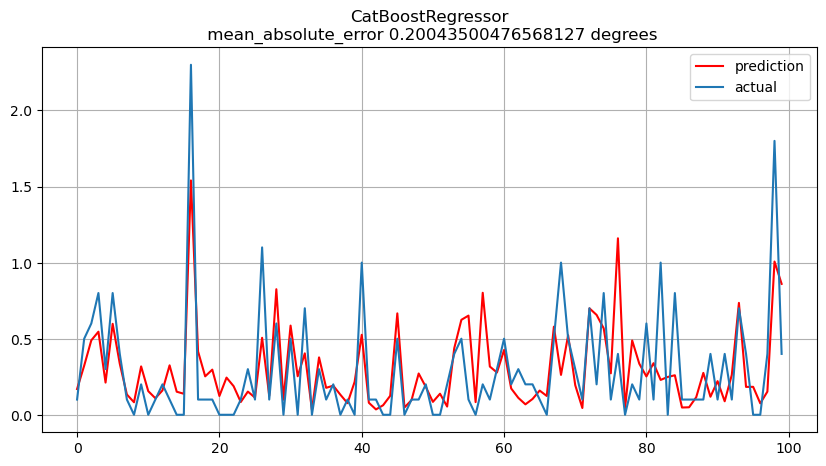

In [26]:
cb3 = CatBoostRegressor(n_estimators=300)
cb3.fit(X_train3, Y_train3)
preds3 = cb3.predict(X_test3)

plt.figure(figsize=(10, 5))
plt.plot(preds3[0:100], "r", label="prediction")
plt.plot(Y_test3.values[0:100], label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"CatBoostRegressor\n mean_absolute_error {mean_absolute_error(Y_test3,preds3)} degrees")

In [27]:
#Лучше всех себя показал бустинг
#Аналогично поступаем с дельтой от цены открытия до нижней границы цены, но для нее будем использовать только бустинг
df_delta_down = pd.concat([df_vol,dfv3,delta_down], axis = 1)
df_delta_down = df_delta_down[0:100000]
df_delta_down = df_delta_down.rename(columns={"taker_q BNB":"buy",0: "sell",1:"ddown","timeopen BNB":"timeopen"})
df_delta_down["timeopen"] = pd.to_datetime(df_delta_down["timeopen"])
df_delta_down = df_delta_down[["timeopen","buy","sell","ddown"]].set_index("timeopen")
print(df_delta_down)

                             buy         sell  ddown
timeopen                                            
2023-01-01 00:00:00   27774.6386   80578.0431    0.4
2023-01-01 00:05:00    7159.3684   16704.9209    0.2
2023-01-01 00:10:00   49649.1984    9965.4600    0.1
2023-01-01 00:15:00   75929.1050   14910.0223    0.2
2023-01-01 00:20:00   22204.3352   14574.5563    0.1
...                          ...          ...    ...
2024-05-13 10:55:00  154718.7293  166002.1012    0.1
2024-05-13 11:00:00  299543.0948  212640.9393    0.6
2024-05-13 11:05:00  397800.0412  270360.4217    0.7
2024-05-13 11:10:00  263328.9406   80231.4319    0.1
2024-05-13 11:15:00  302236.1224  134559.0736    0.0

[100000 rows x 3 columns]


In [28]:
#Целевая переменная ddown - дельта цены от цены открытия до нижней границы цены в периоде
#Разбиваем датафрейм на трейн и тест
X2 = df_delta_down.drop("ddown",axis = 1)
Y2 = df_delta_down["ddown"]
X2_train3, X2_test3, Y2_train3, Y2_test3 = train_test_split(X2, Y2, test_size = 0.15, random_state = 777)

Learning rate set to 0.219851
0:	learn: 0.5041327	total: 2.39ms	remaining: 716ms
1:	learn: 0.4719722	total: 4.06ms	remaining: 605ms
2:	learn: 0.4520423	total: 5.63ms	remaining: 558ms
3:	learn: 0.4373563	total: 7.18ms	remaining: 532ms
4:	learn: 0.4269997	total: 8.71ms	remaining: 514ms
5:	learn: 0.4199622	total: 10.2ms	remaining: 500ms
6:	learn: 0.4148785	total: 11.7ms	remaining: 489ms
7:	learn: 0.4106780	total: 13.1ms	remaining: 479ms
8:	learn: 0.4078388	total: 14.6ms	remaining: 472ms
9:	learn: 0.4058917	total: 16.1ms	remaining: 466ms
10:	learn: 0.4043069	total: 17.6ms	remaining: 464ms
11:	learn: 0.4030464	total: 19.1ms	remaining: 458ms
12:	learn: 0.4019575	total: 20.5ms	remaining: 453ms
13:	learn: 0.4010801	total: 22.1ms	remaining: 451ms
14:	learn: 0.4005331	total: 23.6ms	remaining: 449ms
15:	learn: 0.3997543	total: 25ms	remaining: 444ms
16:	learn: 0.3992045	total: 26.6ms	remaining: 443ms
17:	learn: 0.3987066	total: 28ms	remaining: 438ms
18:	learn: 0.3984156	total: 29.5ms	remaining: 43

Text(0.5, 1.0, 'CatBoostRegressor\n mean_absolute_error 0.204822201716961 degrees')

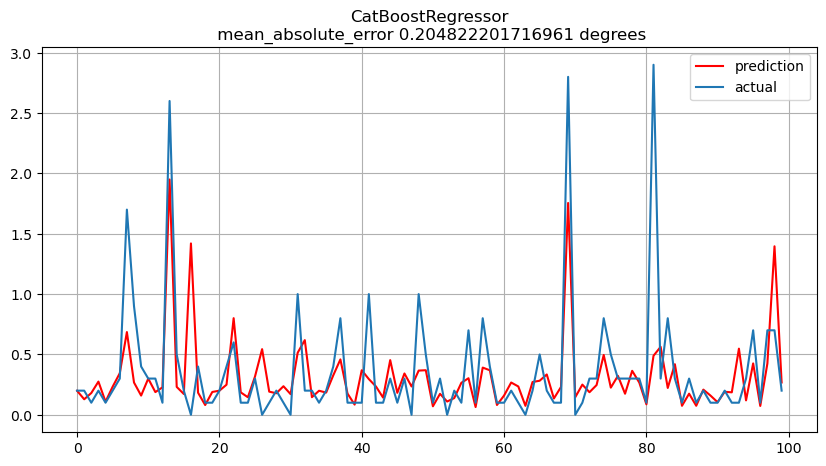

In [29]:
cb4 = CatBoostRegressor(n_estimators=300)
cb4.fit(X2_train3, Y2_train3)
preds4 = cb4.predict(X2_test3)

plt.figure(figsize=(10, 5))
plt.plot(preds4[0:100], "r", label="prediction")
plt.plot(Y2_test3.values[0:100], label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"CatBoostRegressor\n mean_absolute_error {mean_absolute_error(Y2_test3, preds4)} degrees")

In [30]:
#После обучения моделей объема продаж, покупок и дельт цены 
#Теперь попробуем предсказать дельту на основании предсказанного объема покупок и продаж и сравним с реальными результатами,
#т.к. в моменте расчета дельты нам еще не известны полные объемы
#Нам необходимо добавить к предсказанным значениям объема дату и время чтобы потом сджойнить с реальными значениями

In [31]:
#Т.к. очередность во временных рядах сохранена, можно объединить просто по индексу объемы покупок и продаж, либо по дате и времени
#Покупки
df_buy = pd.DataFrame(y_test)
df_buy["buy"]=preds
df_buy = df_buy.reset_index()
df_ind = df[85020:100000]
df_ind = df_ind.reset_index()
df_ind = df_ind["timeopen BNB"]
df_pred = pd.concat([df_ind,df_buy], axis = 1)
df_pred

,timeopen BNB,index,vol,buy
0,2024-03-01 01:40:00,85000,424663.1487,575148.835735
1,2024-03-01 01:45:00,85001,896670.7302,440503.837004
2,2024-03-01 01:50:00,85002,474531.2331,707396.801261
3,2024-03-01 01:55:00,85003,678156.9936,737262.539411
4,2024-03-01 02:00:00,85004,433844.8072,682197.277187
...,...,...,...,...
14975,2024-05-13 10:55:00,99975,154718.7293,355769.725422
14976,2024-05-13 11:00:00,99976,299543.0948,333862.976467
14977,2024-05-13 11:05:00,99977,397800.0412,511138.461041
14978,2024-05-13 11:10:00,99978,263328.9406,485293.324436


In [32]:
#Продажи
df_pred2 = pd.DataFrame(y_test2)
df_pred2["sell"]=preds2
df_pred2 = df_pred2.reset_index()
#Объединение покупок и продаж
df_pred_vol = pd.concat([df_pred,df_pred2["sell"]], axis = 1)
df_pred_vol

,timeopen BNB,index,vol,buy,sell
0,2024-03-01 01:40:00,85000,424663.1487,575148.835735,378268.382622
1,2024-03-01 01:45:00,85001,896670.7302,440503.837004,390231.313205
2,2024-03-01 01:50:00,85002,474531.2331,707396.801261,480125.933740
3,2024-03-01 01:55:00,85003,678156.9936,737262.539411,440573.481835
4,2024-03-01 02:00:00,85004,433844.8072,682197.277187,396591.221423
...,...,...,...,...,...
14975,2024-05-13 10:55:00,99975,154718.7293,355769.725422,398764.730671
14976,2024-05-13 11:00:00,99976,299543.0948,333862.976467,372439.931128
14977,2024-05-13 11:05:00,99977,397800.0412,511138.461041,333157.860947
14978,2024-05-13 11:10:00,99978,263328.9406,485293.324436,321866.739395


In [33]:
#Согласно обученной модели расчитываем дельту от цены открытия до верхней границы цены
df_pred_vol2 = df_pred_vol[["buy","sell"]]
preds5 = cb3.predict(df_pred_vol2)
df_pred_vol["up"] = preds5

In [34]:
#Согласно обученной модели расчитываем дельту от цены открытия до нижней границы цены и умножаем на -1 для удобства отображения
preds6 = cb4.predict(df_pred_vol2)
preds6 = preds6*-1
df_pred_vol["down"] = preds6

In [35]:
# Убираем лишние столбцы и переименуем столбцы для удобства чтения
df_pred_vol = df_pred_vol[["timeopen BNB","buy","sell","up","down"]]
df_pred_vol = df_pred_vol.rename(columns={"timeopen BNB":"timeopen","buy": "buy_pred","sell":"sell_pred","up":"up_pred","down":"down_pred"})
df_pred_vol

,timeopen,buy_pred,sell_pred,up_pred,down_pred
0,2024-03-01 01:40:00,575148.835735,378268.382622,0.618727,-0.309366
1,2024-03-01 01:45:00,440503.837004,390231.313205,0.418194,-0.429073
2,2024-03-01 01:50:00,707396.801261,480125.933740,0.732388,-0.328603
3,2024-03-01 01:55:00,737262.539411,440573.481835,0.779144,-0.297927
4,2024-03-01 02:00:00,682197.277187,396591.221423,0.763012,-0.329409
...,...,...,...,...,...
14975,2024-05-13 10:55:00,355769.725422,398764.730671,0.328667,-0.476823
14976,2024-05-13 11:00:00,333862.976467,372439.931128,0.322289,-0.462865
14977,2024-05-13 11:05:00,511138.461041,333157.860947,0.612511,-0.298920
14978,2024-05-13 11:10:00,485293.324436,321866.739395,0.615533,-0.267480


In [36]:
#Создаем датафрейм с реальными данными, убираем все лишнее и переименуем для удобства
delta_down = delta_down*-1
df_delta = pd.concat([df,delta_up,delta_down,dfv3], axis = 1)
df_delta = df_delta.rename(columns={"timeopen BNB":"timeopen","taker_q BNB":"buy",2:"sell",0:"up",1:"down"})
df_delta = df_delta[["timeopen","buy","sell","up","down"]]
df_delta

,timeopen,buy,sell,up,down
0,2023-01-01 00:00:00,27774.6386,80578.0431,0.1,-0.4
1,2023-01-01 00:05:00,7159.3684,16704.9209,0.0,-0.2
2,2023-01-01 00:10:00,49649.1984,9965.4600,0.0,-0.1
3,2023-01-01 00:15:00,75929.1050,14910.0223,0.2,-0.2
4,2023-01-01 00:20:00,22204.3352,14574.5563,0.3,-0.1
...,...,...,...,...,...
100690,2024-05-17 09:30:00,568696.0126,257090.8815,0.9,-0.3
100691,2024-05-17 09:35:00,278302.3806,278295.4804,0.4,-0.3
100692,2024-05-17 09:40:00,62070.4330,155607.9427,0.1,-0.5
100693,2024-05-17 09:45:00,95605.0614,79181.0369,0.5,-0.1


In [37]:
#Объединяем через внутренний джойн т.к. расчитанных значений всего 15к а реальных данных более 100к и берем для отображения последние 100 значений
df_all = pd.merge(df_pred_vol,df_delta, on = 'timeopen', how = 'inner')
df_all = df_all[-100::]
df_all["timeopen"] = pd.to_datetime(df_all["timeopen"])
df_all

,timeopen,buy_pred,sell_pred,up_pred,down_pred,buy,sell,up,down
14880,2024-05-13 03:00:00,4.287478e+05,5.017128e+05,0.358312,-0.595256,3.310499e+05,5.730803e+05,0.5,-1.1
14881,2024-05-13 03:05:00,6.770186e+05,5.903255e+05,0.641008,-0.578341,9.157923e+05,4.154269e+05,1.0,-0.4
14882,2024-05-13 03:10:00,1.210450e+06,5.024944e+05,1.037584,-0.316942,5.535828e+05,2.084324e+06,0.2,-2.2
14883,2024-05-13 03:15:00,2.897886e+05,1.206204e+06,0.178037,-0.934637,2.119417e+06,9.081772e+05,1.5,-0.3
14884,2024-05-13 03:20:00,1.251094e+06,8.922006e+05,1.193399,-0.485613,6.707275e+05,4.285174e+05,1.7,-0.1
...,...,...,...,...,...,...,...,...,...
14975,2024-05-13 10:55:00,3.557697e+05,3.987647e+05,0.328667,-0.476823,1.547187e+05,1.660021e+05,0.2,-0.1
14976,2024-05-13 11:00:00,3.338630e+05,3.724399e+05,0.322289,-0.462865,2.995431e+05,2.126409e+05,0.6,-0.6
14977,2024-05-13 11:05:00,5.111385e+05,3.331579e+05,0.612511,-0.298920,3.978000e+05,2.703604e+05,0.1,-0.7
14978,2024-05-13 11:10:00,4.852933e+05,3.218667e+05,0.615533,-0.267480,2.633289e+05,8.023143e+04,0.8,-0.1


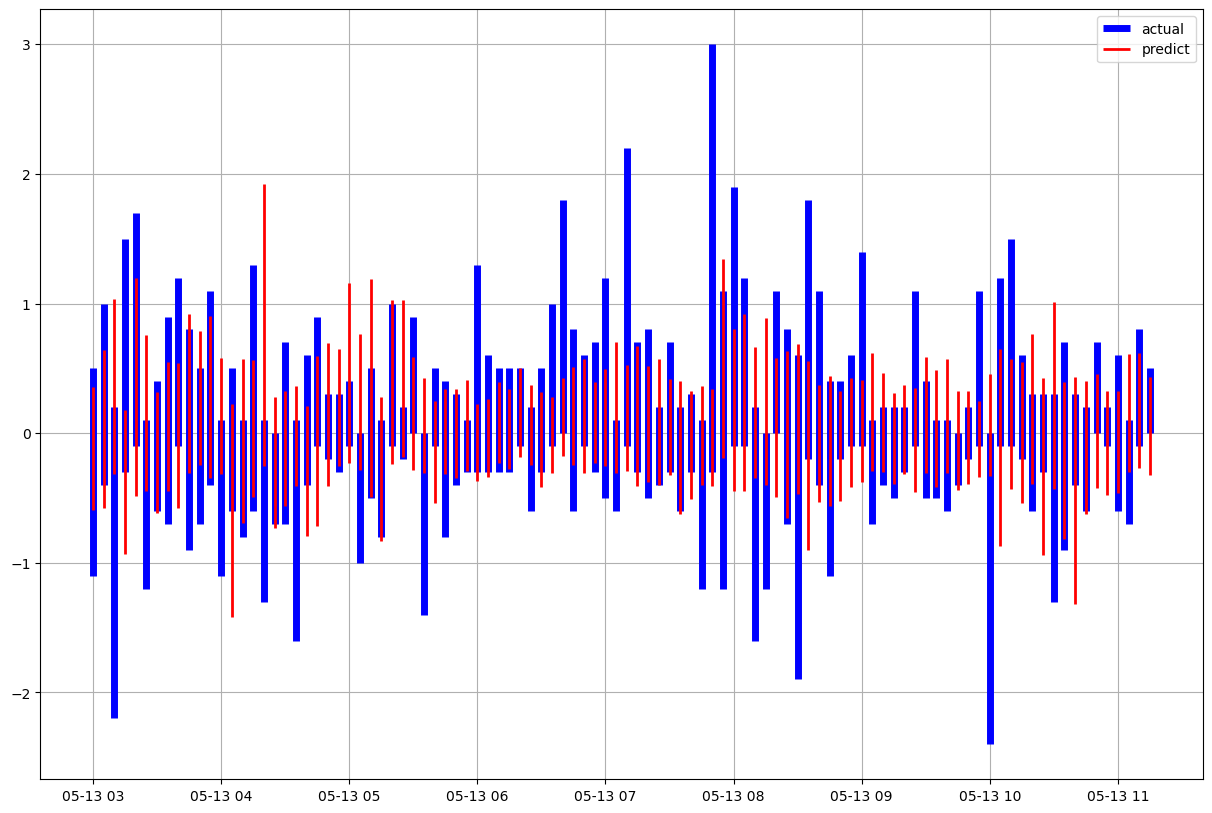

In [38]:
#Выводим на график предсказанные значения и реальные для визуального анализа
plt.figure(figsize=(15, 10))
plt.vlines(df_all["timeopen"],df_all["down"],df_all["up"], linewidth = 5 ,color="b", label="actual")
plt.vlines(df_all["timeopen"],df_all["down_pred"],df_all["up_pred"], linewidth = 2 ,color="r", label="predict")
plt.grid(True)
plt.legend(loc="best")

In [39]:
#Посчитаем абсолютную ошибку дельты от нижней границы цены до цены открытия
mean_absolute_error(df_all["down"], df_all["down_pred"])

0.3707844036906605

In [40]:
#Посчитаем абсолютную ошибку дельты от верхней границы цены до цены открытия
mean_absolute_error(df_all["up"], df_all["up_pred"])

0.4465915422599844

In [41]:
#Вывод: Ошибка достаточно большая, вероятно, нужно добавлять признаки для улучшения результатов.
#Дельты можно использовать для скальпинга и выставления стоп-лоссов и тейк-профитов на временном интервале, что позволит уменьшить риски и увеличить прибыль в сделках.